# 17.2.1 가치 평가 클래스

In [1]:
import numpy as np
from valuation_class import valuation_class

In [2]:
class valuation_mcs_european(valuation_class):
    ''' 단일 요인 몬테카를로 시뮬레이션을 사용한 임의의 페이오프에 대한 유로피안 옵션 가치 평가 클래스
    
    Method
    =======
    generate_payoff : 
        주어진 경로와 페이오프 함수를 이용하여 페이오프 계산
    present_value :
        몬테카를로 방식으로 추정한 현재 가치 반환
    
    '''
    
    def generate_payoff(self, fixed_seed = False):
        '''
        인수
        ====
        fixed_seed : Boolean
             가치 계산용 시드 값을 중복 사용
        '''
        try:
            # 행사가가 정의 되었는지 확인
            strike = self.strike
        
        except:
            pass
        
        paths = self.underlying.get_instrument_values(fixed_seed = fixed_seed)
        time_grid = self.underlying.time_grid
        
        try:
            time_index = np.where(time_grid == self.maturity)[0]
            time_index = int(time_index)
        
        except:
            print('Maturity date not in time grid of underlying')
        
        maturity_value = paths[time_index]
        # 전체 경로에 대한 평균
        mean_value = np.mean(paths[:time_index], axis = 1)
        # 전체 경로에 대한 최대값
        max_value = np.amax(paths[:time_index], axis = 1)[-1]
        # 전체 경로에 대한 최솟값
        min_value = np.amin(paths[:time_index], axis = 1)[-1]
        
        try:
            payoff = eval(self.payoff_func)
            return payoff
        
        except:
            print('Error evaluating payoff function')
            
    def present_value(self, accuracy = 6, fixed_seed = False, full = False):
        '''
        인수
        ====
        accuracy : int
            반환 값의 자리수
        fixed_seed : Boolean
            가치 계산용 시드 값을 중복 사용
        full : Boolean
            현재 값에 대한 1차원 배열도 반환
        
        '''
        cash_flow = self.generate_payoff(fixed_seed = fixed_seed)
        discount_factor = self.discount_curve.get_discount_factors((self.pricing_date, self.maturity))[0, 1]
        result = discount_factor * np.sum(cash_flow) / len(cash_flow)
        
        if full:
            return round(result, accuracy), discount_factor * cash_flow
        else:
            return round(result, accuracy)

# 17.2.2 사용법

In [3]:
from dx_frame import *
from geometric_brownian_motion import geometric_brownian_motion

In [4]:
me_gbm = market_environment('me_gbm', dt.datetime(2015, 1, 1))

In [5]:
me_gbm.add_constant('initial_value', 36.)
me_gbm.add_constant('volatility', 0.2)
me_gbm.add_constant('final_date', dt.datetime(2015, 12, 31))
me_gbm.add_constant('currency', 'EUR')
me_gbm.add_constant('frequency', 'M')
me_gbm.add_constant('paths', 10000)

In [6]:
csr = constant_short_rate('csr', 0.06)

In [7]:
me_gbm.add_curve('discount_curve', csr)

In [8]:
gbm = geometric_brownian_motion('gbm', me_gbm)

In [9]:
# 시뮬레이션 객체 이외의 옵션을 위한 시장 환경 정보
me_call = market_environment('me_call', me_gbm.pricing_date)

In [10]:
me_call.add_constant('strike', 40.)
me_call.add_constant('maturity', dt.datetime(2015, 12, 31))
me_call.add_constant('currency', 'EUR')

In [11]:
payoff_func = 'np.maximum(maturity_value - strike, 0)'

In [ ]:
from valuation_mcs_european import valuation_mcs_european

In [12]:
eur_call = valuation_mcs_european('eur_call', underlying = gbm, mar_env = me_call, payoff_func = payoff_func)

In [13]:
%time eur_call.present_value()

Wall time: 7.96 ms


2.305196

In [14]:
%time eur_call.delta()

Wall time: 7.98 ms


0.5015

In [15]:
%time eur_call.vega()

Wall time: 10.9 ms


15.1587

In [16]:
# 기초자산 가격이 변화 할때 옵션 가치, 델타, 베가 변화 알아보기

In [17]:
%%time
s_list = np.arange(34, 46.1, 2)
p_list = []; d_list = []; v_list = []
for s in s_list:
    eur_call.update(initial_value = s)
    p_list.append(eur_call.present_value(fixed_seed = True))
    d_list.append(eur_call.delta())
    v_list.append(eur_call.vega())

Wall time: 157 ms


In [18]:
# 옵션 통계치를 그리기 위한 보조 함수
import matplotlib.pyplot as plt

def plot_option_stats(s_list, p_list, d_list, v_list):
    ''' 여러가지 기초자산에 대한 옵션 가격, 델타, 베가를 플롯
    
    인수
    ====
    s_list : arrray or list
        기초자산의 값 집합
    p_list : array or list
        현재 가치
    d_list : array or list
        델타 값
    v_list : array or list
        베가 값
    
    '''
    plt.figure(figsize = (9, 7))
    sub1 = plt.subplot(311)
    plt.plot(s_list, p_list, 'ro', label = 'present value')
    plt.plot(s_list, p_list, 'b')
    plt.grid(True); plt.legend(loc = 0)
    plt.setp(sub1.get_xticklabels(), visible = False)
    sub2 = plt.subplot(312)
    plt.plot(s_list, d_list, 'go', label = 'Delta')
    plt.plot(s_list, d_list, 'b')
    plt.grid(True); plt.legend(loc = 0)
    plt.ylim(min(d_list) - 0.1, max(d_list) + 0.1)
    plt.setp(sub2.get_xticklabels(), visible = False)
    sub3 = plt.subplot(313)
    plt.plot(s_list, v_list, 'yo', label = 'Vega')
    plt.plot(s_list, v_list, 'b')
    plt.xlabel('initial value of underlying')
    plt.grid(True); plt.legend(loc = 0)

In [ ]:
form plot_option_stats import plot_option_stats

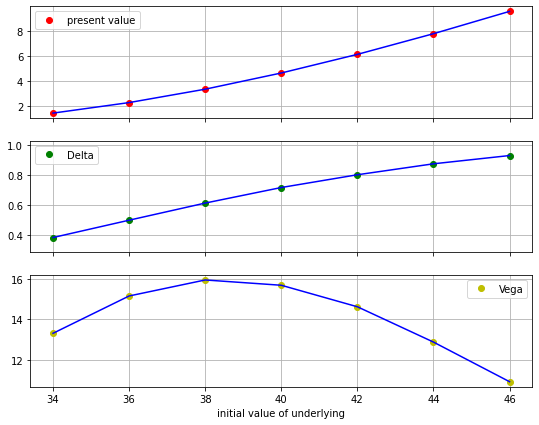

In [19]:
%matplotlib inline
plot_option_stats(s_list, p_list, d_list, v_list)

In [20]:
# 일반 옵션 + 아시안 payoff
payoff_func = 'np.maximum(0.33 * (maturity_value + max_value) - 40, 0)'

In [21]:
eur_as_call = valuation_mcs_european('eur_as_call', underlying = gbm, mar_env = me_call, payoff_func = payoff_func)

In [22]:
%%time
s_list = np.arange(34, 46.1, 2)
p_list = []; d_list = []; v_list = []
for s in s_list:
    eur_call.update(s)
    p_list.append(eur_as_call.present_value(fixed_seed = True))
    d_list.append(eur_as_call.delta())
    v_list.append(eur_as_call.vega())

Wall time: 126 ms


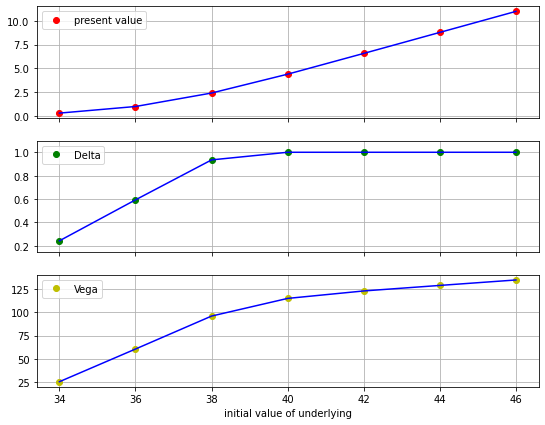

In [23]:
plot_option_stats(s_list, p_list, d_list, v_list)